### Preamble:

These scenarios are based on setting a range of DOY for the snowmelt season occures and for each of those days, pulling a daily snowmelt rate from a distribution of snowmelt rates based on observations, but enlarged by 10% and shifted forward (earlier in the year) 10 days to allow for more rapid snowmelt rates and a wider range of daily snowmelt rates. Once the timeseries of snowmelt rates is generates the average snowmelt rate is computed and then the timeseries is scaled to the desired average snowmelt rate dictated by the length and timing of the ablation season and peak swe for the scenario.

In [1]:
import rhessys.utilities as rut
from matplotlib.patches import Polygon
import statsmodels.api as sm

In [2]:
dat = pd.read_pickle('./data/Vcm_cosmos_pillow_swe.pcl')

In [3]:
dat.loc[dat.swe<0.5,'swe'] = 0.
dat.swe /= 100. # cm > m

In [4]:
dat['wateryear'] = dat.index.map(rut.wateryear)

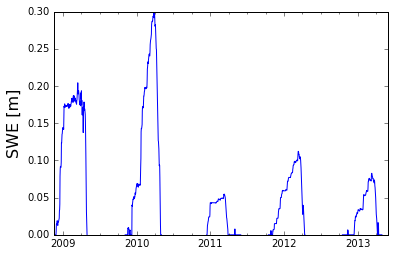

In [5]:
dat.swe.plot()
plt.ylabel('SWE [m]', fontsize=16)

In [6]:
stats = pd.DataFrame()
stats['wateryear'] = dat.wateryear.unique()

for wy in dat.wateryear.unique():
    tmp = dat.loc[dat.wateryear == wy]
    
    dopeakswe = tmp.swe.argmax()
    peakswe = tmp.swe.max()
    
    stats.loc[stats.wateryear==wy,'doaccum'] = tmp.loc['%s-10-01'%(wy-1):dopeakswe].swe.argmin()
    stats.loc[stats.wateryear==wy,'dosnowfree'] = tmp.loc[dopeakswe:'%s-09-30'%wy].swe.argmin()
    stats.loc[stats.wateryear==wy,'dopeakswe'] = dopeakswe
    stats.loc[stats.wateryear==wy,'peakswe'] = peakswe
    

In [7]:
def compute_dowy(dt):
    year = dt.year
    month = dt.month
    day = dt.day
    wy = rut.wateryear(dt)
    
    timedelta = dt-pd.datetime.strptime('%s-10-1'%(wy-1),'%Y-%m-%d')   
    
    return timedelta.days

In [8]:
stats['dowy_accum'] = stats.doaccum.map(compute_dowy)
stats['dowy_snowfree'] = stats.dosnowfree.map(compute_dowy)
stats['dowy_peakswe'] = stats.dopeakswe.map(compute_dowy)

In [9]:
stats.to_pickle('./data/vcm_swe_stats.pcl')

In [10]:
stats

,wateryear,doaccum,dosnowfree,dopeakswe,peakswe,dowy_accum,dowy_snowfree,dowy_peakswe
0,2009,2008-11-14,2009-04-29,2009-03-14,0.204290,44,210,164
1,2010,2009-11-04,2010-04-29,2010-03-29,0.299106,34,210,179
2,2011,2010-12-14,2011-03-29,2011-03-11,0.054683,74,179,161
3,2012,2011-10-15,2012-04-12,2012-03-11,0.112225,14,194,162
4,2013,2012-10-16,2013-04-08,2013-03-11,0.082608,15,189,161


### Generate the SWE Triangles

In [11]:
peakswe = stats.peakswe.mean()
DOAS = stats.dowy_accum.mean()
DONS = stats.dowy_snowfree.mean()
DOWYpeakSWE = stats.dowy_peakswe.mean()

peakswe90 = np.percentile(stats.peakswe,90)
DOAS90 = np.percentile(stats.dowy_accum,90)
DONS90 = np.percentile(stats.dowy_snowfree,90)
DOWYpeakSWE90 = np.percentile(stats.dowy_peakswe,90)

peakswe10 = np.percentile(stats.peakswe,10)
DOAS10 = np.percentile(stats.dowy_accum,10)
DONS10 = np.percentile(stats.dowy_snowfree,10)
DOWYpeakSWE10 = np.percentile(stats.dowy_peakswe,10)

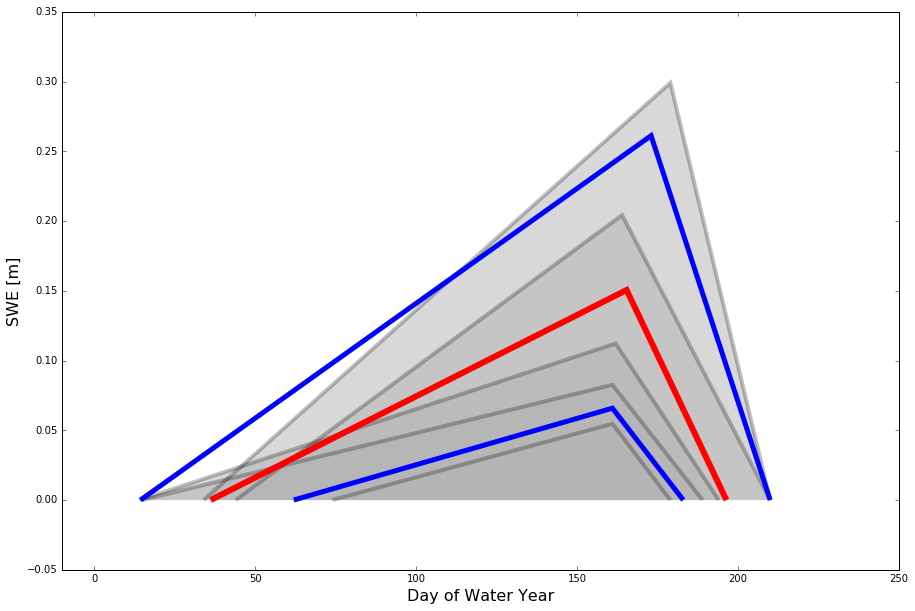

In [12]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

for wy in np.unique(stats.index):
    
    x1 = stats.loc[stats.index==wy,'dowy_accum'].as_matrix()[0]
    x2 = stats.loc[stats.index==wy,'dowy_snowfree'].as_matrix()[0]
    x3 = stats.loc[stats.index==wy,'dowy_peakswe'].as_matrix()[0]
    y3 = stats.loc[stats.index==wy,'peakswe'].as_matrix()[0]
    
    pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
    p = Polygon(pts, closed=False, alpha = 0.5,edgecolor='none',facecolor='0.7')
    ax.add_patch(p)
    
for wy in np.unique(stats.index):
    
    x1 = stats.loc[stats.index==wy,'dowy_accum'].as_matrix()[0]
    x2 = stats.loc[stats.index==wy,'dowy_snowfree'].as_matrix()[0]
    x3 = stats.loc[stats.index==wy,'dowy_peakswe'].as_matrix()[0]
    y3 = stats.loc[stats.index==wy,'peakswe'].as_matrix()[0]
    
    pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
    p = Polygon(pts, closed=False, alpha = 0.25,edgecolor='k',facecolor='none',lw=4)
    ax.add_patch(p)

x1 = DOAS
x2 = DONS
x3 = DOWYpeakSWE
y3 = peakswe

pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
p = Polygon(pts, closed=False, alpha = 1,edgecolor='r',facecolor='none',lw=6)
ax.add_patch(p)

x1 = DOAS10
x2 = DONS90
x3 = DOWYpeakSWE90
y3 = peakswe90

pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
p = Polygon(pts, closed=False, alpha = 1,edgecolor='b',facecolor='none',lw=5)
ax.add_patch(p)

x1 = DOAS90
x2 = DONS10
x3 = DOWYpeakSWE10
y3 = peakswe10

pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
p = Polygon(pts, closed=False, alpha = 1,edgecolor='b',facecolor='none',lw=5)
ax.add_patch(p)    

ax.set_xlim(-10,250)
ax.set_ylim(-.05,.35)
plt.xlabel('Day of Water Year', fontsize = 16)
plt.ylabel('SWE [m]', fontsize=16)

## Generate a data frame of Snowmelt Events

In [13]:
dat['dowy'] = dat.index.map(compute_dowy)

In [14]:
# compute snowmelt based on SWE
tmp1 = dat.swe.as_matrix()[0:-1]
tmp2 = dat.swe.as_matrix()[1:]

dat['sm'] = np.nan

dat.ix[1:,'sm'] = tmp2-tmp1

In [16]:
dates = [] # preallocate actual dates
snowmelts = [] # preallocate snowmelt rates
DOAS = [] # preallocate date of ablation season array

for wy in np.unique(stats.wateryear): # loop through each water year and extract each snowmelt season
    
    strt = stats.loc[stats.wateryear==wy,'dopeakswe'].as_matrix()[0] # get the date of peak SWE
    nd = stats.loc[stats.wateryear==wy,'dosnowfree'].as_matrix()[0] # get the date of no snow
    
    smelt = list(dat.loc[strt:nd,'sm'])
    
    snowmelts.extend(list(smelt)) # pull out the snowmelts
    DOAS.extend(list(np.arange(1,len(smelt)+1))) # create an array of ablation season days
    dates.extend(list(pd.date_range(strt,nd,freq='D'))) # create an array of actual days

In [17]:
# generate an array snowmelt events and the day of the water year that they occured on.
AS = pd.DataFrame({'snowmelt':snowmelts,'DOAS':DOAS,'date':dates})
AS['DOWY'] = AS.date.map(rut.DOWY)
AS['DOWY2'] = AS.DOWY**2

In [18]:
AS.head() # SM in m/day

,DOAS,date,snowmelt,DOWY,DOWY2
0,1,2009-03-14,0.006893,165,27225
1,2,2009-03-15,-0.006378,166,27556
2,3,2009-03-16,-0.008575,167,27889
3,4,2009-03-17,0.004370,168,28224
4,5,2009-03-18,0.000323,169,28561


In [19]:
AS.snowmelt *= -1 # convert decreases in SWE to positive snowmelt values
AS.loc[AS.snowmelt < 0, 'snowmelt'] = np.NaN # remove accumulation events

#AS.dropna(inplace=True)

In [20]:
AS = AS.loc[AS.snowmelt>=0,:] # remove Accumulation events

In [21]:
smvals = AS.copy()

In [22]:
del smvals['date']
del smvals['DOWY2']
del smvals['DOAS']

In [23]:
smvals.sort_values(by='snowmelt', inplace=True)
smvals.reset_index(inplace=True)

In [24]:
# timeshift and increase the observed snowmelt scenarios multiple times up to the maximum for both so make a more dense distribution of snowmelt rates
n = 20 # number of times to split up the shifts and increases
# maximum values
timeshift = 10 # move snowmelt forward by 10 days
rateincrease = 1.1 # increase the rate by 10%

timeshifts = np.linspace(0,timeshift,num=n)
rateincreases = np.linspace(1,rateincrease,num=n)

tmp = pd.DataFrame() # preallocate data frame
ct = 0
for k,l in zip(timeshifts,rateincreases):
    dowys = np.round(smvals.DOWY.as_matrix()-k) # shift timing forward by the timeshift 
    sms = smvals.snowmelt.as_matrix()*l # increase snowmelt rates by the rate increase

    tmp = pd.concat([pd.DataFrame({'snowmelt':sms,'DOWY':dowys}),tmp])
    
    #print ct 
    #print 'Snowmelt values shifted forward %s days'%k
    #print 'Snowmelt values multiplied by %s'%l
    
    ct += 1

In [25]:
smvals = pd.concat([tmp,smvals])
del smvals['index']

In [26]:
smvals.sort_values(by='snowmelt', inplace=True)
smvals.reset_index(inplace=True)

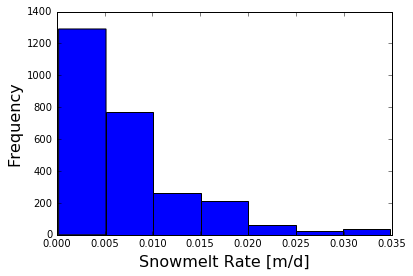

In [27]:
plt.hist(smvals.snowmelt,7);
plt.xlabel('Snowmelt Rate [m/d]', fontsize = 16)
plt.ylabel('Frequency', fontsize=16)

In [28]:
strtDOWY = AS.DOWY.min()
endDOWY = AS.DOWY.max()

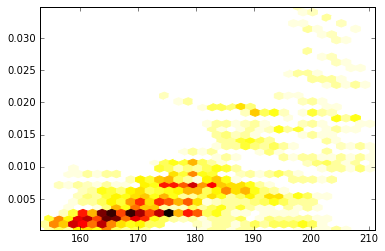

In [29]:
plt.hexbin(smvals.DOWY,smvals.snowmelt,gridsize=35,mincnt=1, cmap='hot_r');

In [30]:
import rhessys.snowmelt_experiment as smex

In [31]:
stats.head()

,wateryear,doaccum,dosnowfree,dopeakswe,peakswe,dowy_accum,dowy_snowfree,dowy_peakswe
0,2009,2008-11-14,2009-04-29,2009-03-14,0.204290,44,210,164
1,2010,2009-11-04,2010-04-29,2010-03-29,0.299106,34,210,179
2,2011,2010-12-14,2011-03-29,2011-03-11,0.054683,74,179,161
3,2012,2011-10-15,2012-04-12,2012-03-11,0.112225,14,194,162
4,2013,2012-10-16,2013-04-08,2013-03-11,0.082608,15,189,161


In [32]:
meanPeakSWE = round(stats.peakswe.mean(),3)
PeakSWEstd = round(stats.peakswe.std(),3)

meanDOWYpeakSWE = round(stats.dowy_peakswe.mean(),0)
DOWYpeakSWEstd = round(stats.dowy_peakswe.std(),0)

meanDOWYsnowfree = round(stats.dowy_snowfree.mean(),0)
DOWYsnowfreestd = round(stats.dowy_snowfree.std(),0)

print 'mean peak SWE: %s +/-%s'%(meanPeakSWE,PeakSWEstd)
print 'mean DOWY peak SWE: %s +/-%s'%(meanDOWYpeakSWE,DOWYpeakSWEstd)
print 'mean DOWY no snow: %s +/-%s'%(meanDOWYsnowfree,DOWYsnowfreestd)

mean peak SWE: 0.151 +/-0.1
mean DOWY peak SWE: 165.0 +/-8.0
mean DOWY no snow: 196.0 +/-14.0


In [33]:
# parameters of the snowmelt experiment, bounds are mean +/- 1 standard deviation

TpeakSWEs = np.arange(meanDOWYpeakSWE-DOWYpeakSWEstd,meanDOWYpeakSWE+DOWYpeakSWEstd,1) # Range for the timing of peak SWE
TnoSnow = np.arange(meanDOWYsnowfree-DOWYsnowfreestd,meanDOWYsnowfree+DOWYsnowfreestd,1) # range of the timing of no snow
peakswe = np.linspace(meanPeakSWE-PeakSWEstd,meanPeakSWE+PeakSWEstd,224) # range of peak SWE, 65 was used for Nwt

In [34]:
TPS = []
TNS = []
PS = []
for i in TpeakSWEs:
    for k in TnoSnow:
        for d in peakswe:
            TPS.append(i)
            TNS.append(k)
            PS.append(d)

params = pd.DataFrame({'TpeakSWE':TPS,'Tnosnow':TNS,'peakSWE':PS})

In [35]:
# drop rows with imposible combinations
params['SMR'] = params['peakSWE']/(params['Tnosnow']-params['TpeakSWE']) # compute the average snowmelt rate
params.loc[(params['Tnosnow']-params['TpeakSWE'])<1] = np.NaN
params.loc[params.SMR>np.percentile(smvals.snowmelt,95)] = np.NaN # remove crazy big snowmelt rates
params.dropna(inplace=True)

In [36]:
len(params)

100168

In [37]:
# calculate a bunch of things
params['ref'] = 2012 # add a reference water year
params['date_ONS'] = params.apply(smex.DONS2cal, axis=1) # compute the day of water year for no snow
params['DOAS'] = 15 # compute the day of water year for the beginning of accumulation
params['date_AS'] = params.apply(smex.DOAS2cal, axis=1) # compute the date for the beginning of accumulation
params['idx'] = np.arange(0,len(params)) # add an index column
params['date_peakSWE']=params.apply(smex.DOPEAKSWE2cal,axis=1)

In [38]:
params.to_pickle('./data/params_Vcm_smex_method4.pcl') # save 

In [46]:
def grabsnowmeltval(dowy):
    '''Given a day of water year and a data set of day of water year and snowmelt values, produce a snowmelt value'''
    
    tmp = smvals.loc[smvals.DOWY==dowy] # subset the data frame
    tmp.reset_index(inplace=True)
    m = len(tmp) # grab the number of values
    #print m    
    idx = np.random.randint(0,m,1)
    return tmp.ix[idx,'snowmelt'].as_matrix() # select the random snowmelt value

In [47]:
def genSMcurve(x):
    PSWE = x.peakSWE # new peak SWE [m]
    SMR = x.SMR # new snowmelt rate [m/d]
    tPeakSWE = x.TpeakSWE # new day of water year of peak SWE [DOWY]
    tNoSnow = x.Tnosnow # the day of water year of no snow
    
    # Generate a list of DOWY
    res = pd.DataFrame({'dowy':np.arange(tPeakSWE,tNoSnow)}) # create a data frame
    
    res['sm'] = res.dowy.map(grabsnowmeltval) # map the snowmelt function onto the DF returns sm in [m/d]
    
    meanSMR = np.mean(res.sm) # compute the mean snowmelt rate [m/d]
    diff = SMR/meanSMR # compute the ratio [1]
    res['sm'] *= diff # scale the snowmelt curve to match the correct one
    
    # handle the dates
    res['ref'] = 2012 # create a reference year column
    res['date'] = res.apply(smex.DOWY2cal,axis=1)
    res['year'] = res.date.map(smex.getyear)
    res['month'] = res.date.map(smex.getmonth)
    res['day'] = res.date.map(smex.getday)
    res['hour'] = 1. # create an hour column
    
    # create an array for export
    
    years = res.year.as_matrix()
    months = res.month.as_matrix()
    days = res.day.as_matrix()
    hours = res.hour.as_matrix()
    sm = res.sm.as_matrix()
    
    # reshape the arrays
    years = np.reshape(years,[len(years),1]) 
    months = np.reshape(months,[len(months),1]) 
    days = np.reshape(days,[len(days),1]) 
    hours = np.reshape(hours,[len(hours),1]) 
    sm = np.reshape(sm,[len(sm),1]) 
    
    out = np.concatenate((years,months,days,hours,sm),axis=1) # concat the arrays
    
    filenum = int(x.idx)
    
    np.savetxt('/RHESSys/jemez/clim/smexperiment/smex4/hourly/scen_'+str(filenum)+'.snow_melt_input',out,fmt='%i %i %i %i %10.8f',
              comments='',header=str(len(years)))

In [48]:
def genrain(x):
    
    rain = crn.loc['2011-10-1':'2012-10-15','P'].copy() # subset the P, units should be m
    rain2 = crn.loc['2011-10-1':'2012-10-15','P'].copy()
    
    strt = x.date_peakSWE # beginning of snowmelt
    strt2 = x.date_AS # beginning of the snow season
    nd = x.date_ONS-pd.datetools.timedelta(1) # end of the snow season
    
    
    rain[str(strt):str(nd)] = 0. # zero the rain for peak swe to DONS, so it builds a snowpack 
    rain2[str(strt2):str(nd)] = 0. # zero the rain for the snow season
    
    header = '2011 10 1'
    
    rn = rain.as_matrix()
    rn = np.reshape(rn,[len(rn),1])
    
    filenum = int(x.idx)
    
    np.savetxt('/RHESSys/jemez/clim/smexperiment/smex4/daily/vcm_hybrid_'+str(filenum)+'.rain',
               rn,comments='',header=header,fmt='%10.8f')
    
    return rain2['2011-10-01':'2012-9-30'].sum() # return the total rain for the water year

In [49]:
tmp = pd.read_pickle('./data/Vcm_hybrid_precip.pcl')
crn = pd.DataFrame(tmp['hybrid_p'])

In [50]:
crn.columns = ['P']
crn.P *= 0.001 # mm to m

In [51]:
params.apply(genSMcurve,axis=1);
print 'Done with snowmelt scenarios'
params['MAP'] = params.apply(genrain,axis=1)
print 'Done with rain timeseries'

Done with snowmelt scenarios
Done with rain timeseries


In [53]:
params.shape

(100168, 11)

In [52]:
params.to_pickle('./data/params_Vcm_smex_method4.pcl') # save 